## Load Libraries

In [1]:
from sklearn import datasets

In [36]:
import numpy as np
import pandas as pd
import pandas.plotting as pplt
import matplotlib.pyplot as plt

In [172]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support, make_scorer
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, LogisticRegression

In [43]:
plt.rcParams['figure.figsize'] = (15, 5)

### Load Data

In [28]:
X,y = datasets.load_iris(return_X_y=True, as_frame=True)

In [30]:
X.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [31]:
target.head(3)

0    0
1    0
2    0
Name: target, dtype: int32

### EDA Analysis

<AxesSubplot:>

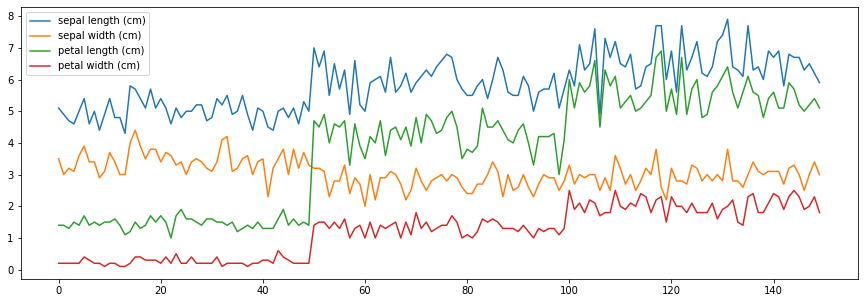

In [45]:
X.plot()

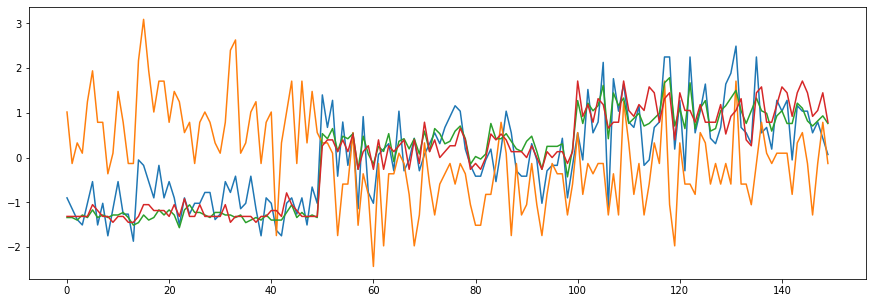

In [44]:
mm_scl = MinMaxScaler()
std_scl = StandardScaler()
plt.plot(std_scl.fit_transform(X))

In [35]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [46]:
# Outlier Handling

<AxesSubplot:>

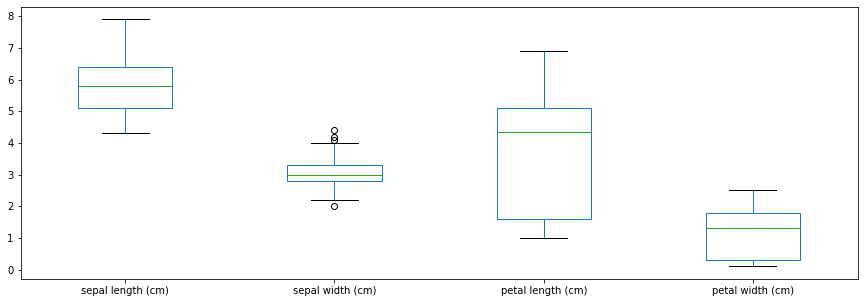

In [47]:
X.plot(kind='box')

In [49]:
X['sepal width (cm)'].quantile([i/10 for i in range(11)])

0.0    2.00
0.1    2.50
0.2    2.70
0.3    2.80
0.4    3.00
0.5    3.00
0.6    3.10
0.7    3.20
0.8    3.40
0.9    3.61
1.0    4.40
Name: sepal width (cm), dtype: float64

In [50]:
def get_iqr(x):
    q25 = x.quantile(.25)
    q75 = x.quantile(.75)
    dif = q75-q25
    ll = q25 - (1.5 *dif)
    ul = q75 + (1.5*dif)
    return ll, ul

In [58]:
ll, ul = get_iqr(X['sepal width (cm)'])

In [60]:
 ul

4.05

In [68]:
flags = (ll <=X['sepal width (cm)']) & ((ul>=X['sepal width (cm)']))

In [69]:
sum(flags)

146

In [70]:
X = X[flags]
y = y[flags]

### After Outlier removal. 

In [71]:
print("X shape", X.shape)
print("y shape", y.shape)

X shape (146, 4)
y shape (146,)


#### Correlation 

In [72]:
cor_matrix = X.corr()

In [75]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]


In [76]:
print("Columns to be dropped", to_drop)

Columns to be dropped ['petal width (cm)']


In [77]:
X.drop(to_drop, axis=1, inplace=True)

C:\Users\Vivek.ananthan\Anaconda3\envs\deepcpu\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [110]:
mm_scl = MinMaxScaler()
std_scl = StandardScaler()
nm_scl = Normalizer()

In [159]:
lr_pipe = Pipeline(steps=[
    ('scaler',std_scl),
    ('mdl',LogisticRegression())
])

In [160]:
def cus_f1(y,yhat):
    f1 = f1_score(y,yhat,average='micro')
    return f1

f1_custom = make_scorer(cus_f1)

In [161]:
cv_score = cross_val_score(lr_pipe,X,y,scoring =f1_custom)

In [162]:
cv_score, cv_score.mean(), cv_score.std()

(array([0.86666667, 1.        , 0.89655172, 0.93103448, 0.96551724]),
 0.9319540229885057,
 0.047483369361982324)

In [163]:
param_grid = {'mdl__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'mdl__max_iter':[100,200,500]}

In [164]:
grid_cv = GridSearchCV(lr_pipe, param_grid=param_grid )

In [165]:
grid_cv.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mdl', LogisticRegression())]),
             param_grid={'mdl__max_iter': [100, 200, 500],
                         'mdl__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga']})

In [167]:
grid_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('mdl', LogisticRegression(solver='newton-cg'))])

In [170]:
cv_score = cross_val_score(grid_cv.best_estimator_,X,y)

In [171]:
cv_score, cv_score.mean(), cv_score.std()

(array([0.86666667, 1.        , 0.89655172, 0.93103448, 0.96551724]),
 0.9319540229885057,
 0.047483369361982324)

In [ ]:
xgb = XGBClassifier()